In [110]:
import datetime as dt

import numpy as np
import os

import pandas as pd

%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn.feature_selection import RFECV

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import joblib

from libs.container import Container
import dataset

In [2]:
cpu = joblib.cpu_count()

In [3]:
sel = joblib.load("results/rfecv_svm_linear.pkl.bz2")

In [4]:
count = {}
resume = {"Feature": dataset.FEATURES}
for key, rfe_data in sel.items():
    clf = rfe_data["selector"]
    count[key] = clf.support_.sum()
    key = "-".join(key)
    print(f"[{key}] Selected Features: ", clf.support_.sum())
    resume.update({
        f"{key} Selected": clf.support_, 
        f"{key} Ranking": clf.ranking_, 
        f"{key} Score": clf.grid_scores_})
resume.keys()

rdf = pd.DataFrame(resume)
rdf = rdf.reset_index(drop=True)

rdf["Mean Score"] = rdf[rdf.columns[rdf.columns.str.endswith(" Score")]].mean(axis=1)
rdf["Selected N"] = rdf[rdf.columns[rdf.columns.str.endswith(" Selected")]].sum(axis=1)

[b261-b277] Selected Features:  14
[b261-b278] Selected Features:  32
[b261-b360] Selected Features:  4
[b277-b278] Selected Features:  22
[b277-b360] Selected Features:  8
[b278-b360] Selected Features:  3


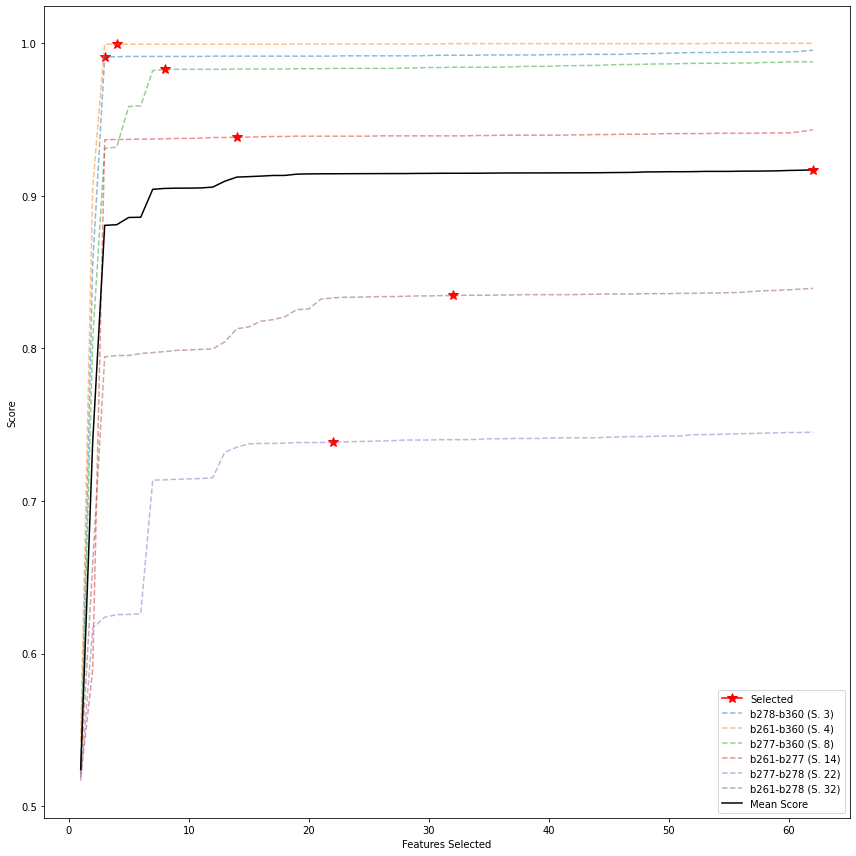

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))

selected_label = "Selected"
for key in sorted(sel.keys(), key=count.get):
    cnt = count[key]
#     if cnt < 10:
#         continue
    
    key = "-".join(key)
    scores = sorted(rdf[f"{key} Score"].values)
    selected = rdf[f"{key} Selected"].sum()
    
    label = f"{key} (S. {selected})"
    
    ax.plot(selected, scores[selected], color="r", marker="*", markersize=10, label=selected_label)
    ax.plot(range(1, len(scores) + 1), scores, alpha=.5, ls="--", label=label)
    
    selected_label = "_no_label_"
    

label = f"Mean Score"
mfeats = range(1, len(scores) + 1)
mscores = sorted(rdf["Mean Score"].values)
plt.plot(mfeats, mscores, label=label, color="k")

amax = np.argmax(mscores)
ax.plot(mfeats[amax], mscores[amax], color="r", marker="*", markersize=10, label=selected_label)
    
ax.set_xlabel("Features Selected")
ax.set_ylabel("Score")

# plt.plot(range(1, len(sel.grid_scores_) + 1), sel.grid_scores_)
# plt.axvline(selected, c="r", alpha=0.5, ls="--", label=f"Features óptimos ({selected})")
plt.legend()
plt.tight_layout()
plt.savefig("plots/rfe.pdf")
plt.show()

In [6]:
(14+30+2+21+9+2)/6

13.0

In [7]:
colors = {
    6: "#ccebc5",
    5: "#ccebd9",
    4: "#b3cde3",
    3: "#decbe4",
    2: "#ffffcc",
    1: "#fbb4ae",   
}

def color_selected(row):
    color = colors.get(row["Selected N"])
    if color is not None:
        return pd.Series(f'background-color: {color}; color: black', row.index)
    
    return pd.Series('', row.index)

resume = rdf[rdf.columns[(
    rdf.columns.str.endswith(" Selected") | 
    rdf.columns.str.startswith("Feature") |
    rdf.columns.str.startswith("Selected N"))]
].sort_values("Selected N", ascending=False).reset_index(drop=True)

html = resume.style.apply(color_selected, axis=1)
html

,Feature,b261-b277 Selected,b261-b278 Selected,b261-b360 Selected,b277-b278 Selected,b277-b360 Selected,b278-b360 Selected,Selected N
0,n09_c3,True,True,True,True,True,True,6
1,c89_hk_color,True,True,True,True,True,True,6
2,c89_c3,True,True,True,True,True,True,6
3,n09_hk_color,True,True,True,True,True,False,5
4,c89_m2,True,True,False,True,True,False,4
5,n09_m4,True,True,False,True,True,False,4
6,n09_m2,True,True,False,True,True,False,4
7,c89_m4,True,True,False,True,True,False,4
8,Rcs,True,True,False,True,False,False,3
9,n09_jk_color,True,True,False,True,False,False,3


In [8]:
resume[resume["Selected N"] >= 4].Feature.values

array(['n09_c3', 'c89_hk_color', 'c89_c3', 'n09_hk_color', 'c89_m2',
       'n09_m4', 'n09_m2', 'c89_m4'], dtype=object)

In [9]:
rfe_ensemble6 = resume[resume["Selected N"] >= 6].Feature.values
rfe_ensemble5 = resume[resume["Selected N"] >= 5].Feature.values
rfe_ensemble4 = resume[resume["Selected N"] >= 4].Feature.values
rfe_ensemble3 = resume[resume["Selected N"] >= 3].Feature.values
rfe_ensemble2 = resume[resume["Selected N"] >= 2].Feature.values

In [75]:
def execute_kfold(*, clf_name, clasificator, sample,  X_columns, y_column, nfolds):
    
    skf = StratifiedKFold(n_splits=nfolds)
    
    X = sample[X_columns].values
    y = sample[y_column].values
    
    probabilities = None
    predictions = np.array([])
    y_tests = np.array([])
    
    for train, test in skf.split(X, y):
        x_train = X[train]
        y_train = y[train]
        x_test = X[test]
        y_test = y[test]
        
        clf = sklearn.clone(clasificator)
        clf.fit(x_train, y_train)
        
        current_pred = clf.predict(x_test)
        current_prob = clf.predict_proba(x_test)
        
        y_tests = np.hstack([y_tests, y_test])
        predictions = np.hstack([predictions, current_pred])
        probabilities = (
                current_prob if probabilities is None else
                np.vstack([probabilities, current_prob ]))
            
    fpr, tpr, thresholds = metrics.roc_curve(
        y_tests, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_tests, 1.- probabilities[:,0], pos_label=1)
    
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_tests, predictions))
    print("-" * 80)
    
    result = {
        "clf_name": clf_name,
        "nfolds": nfolds,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_tests,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_tests, predictions)}    
    return result

In [107]:
BEST_PARAMS["rf"].best_params_

{'criterion': 'entropy',
 'max_features': 0.5,
 'min_samples_split': 5,
 'n_estimators': 500,
 'n_jobs': 10}

In [11]:
data = dataset.load_tile_clf()

BEST_PARAMS = joblib.load("results/hp_selection.pkl.bz2") 
svcl_params = BEST_PARAMS["svc_linear"].best_params_
svcl_params

{'C': 100, 'kernel': 'linear', 'probability': True}

In [12]:
def split_feats(rdf, ta, tb):
    key = f"{ta}-{tb} Selected"
    df = rdf[["Feature", key]]
    
    all_feats = df["Feature"].values
    selected = df[df[key] == True]["Feature"].values
    no_selected = df[df[key] == False]["Feature"].values
    
    return all_feats, selected, no_selected

In [89]:
%%time

fname = "results/rfe_vs_notrfe_vs_allf.pkl.bz2"
if os.path.exists(fname):
    buff = joblib.load(fname)
else:
    buff = {}

keys = rdf.columns[rdf.columns.str.endswith(" Selected")].values
for tiles in keys:
    tile_a, tile_b = tiles.split()[0].split("-")
    print("Starting:", tile_a, tile_b)
    if (tile_a, tile_b) not in buff:
        buff[(tile_a, tile_b)] = {}
    
    sample = pd.concat([data[tile_a], data[tile_b]])
    unscaled, sample,  scl = dataset.scale(sample)
    
    cls = {name: idx for idx, name in enumerate(sample.tile.unique())}
    print(cls)
    sample["cls"] = sample.tile.apply(cls.get)
    
    all_feats, selected, no_selected = split_feats(rdf, tile_a, tile_b)
    
    print(dt.datetime.now(), "CLF")
    if "full" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=all_feats, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["full"] = clf
        joblib.dump(buff, fname, compress=3)
        
    print(dt.datetime.now(), "RFE")
    if "rfe" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=selected, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["rfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    print(dt.datetime.now(), "NOT-RFE")
    if "nrfe" not in buff[(tile_a, tile_b)]:
        clf = execute_kfold(
            clf_name="SVM-Linear", 
            clasificator=SVC(**svcl_params), 
            sample=sample, X_columns=no_selected, y_column="cls", nfolds=5)
        buff[(tile_a, tile_b)]["nrfe"] = clf
        joblib.dump(buff, fname, compress=3)
    
    for ensn in [2, 3, 4, 5, 6]:
        ekey = f"rfe_ensemble{ensn}"
        ecolumns = globals()[ekey]
        print(dt.datetime.now(), f"RFE Ensemble {ensn}")
        
        if ekey not in buff[(tile_a, tile_b)]:
            clf = execute_kfold(
                clf_name="SVM-Linear", 
                clasificator=SVC(**svcl_params), 
                sample=sample, X_columns=ecolumns, y_column="cls", nfolds=5)
            buff[(tile_a, tile_b)][ekey] = clf
            joblib.dump(buff, fname, compress=3)
    
    print("-" * 20)
    
buff_tiles = buff
del buff

Starting: b261 b277
{'b261': 0, 'b277': 1}
2020-10-23 21:39:43.925137 CLF
2020-10-23 21:39:43.925283 RFE
2020-10-23 21:39:43.925351 NOT-RFE
2020-10-23 21:39:43.925421 RFE Ensemble 2
2020-10-23 21:39:43.925488 RFE Ensemble 3
2020-10-23 21:39:43.925555 RFE Ensemble 4
2020-10-23 21:39:43.927199 RFE Ensemble 5
2020-10-23 21:39:43.927282 RFE Ensemble 6
--------------------
Starting: b261 b278
{'b261': 0, 'b278': 1}
2020-10-23 21:39:44.124691 CLF
2020-10-23 21:39:44.124835 RFE
2020-10-23 21:39:44.124902 NOT-RFE
2020-10-23 21:39:44.124971 RFE Ensemble 2
2020-10-23 21:39:44.125040 RFE Ensemble 3
2020-10-23 21:39:44.125106 RFE Ensemble 4
2020-10-23 21:39:44.125172 RFE Ensemble 5
2020-10-23 21:39:44.125238 RFE Ensemble 6
--------------------
Starting: b261 b360
{'b261': 0, 'b360': 1}
2020-10-23 21:39:44.331790 CLF
2020-10-23 21:39:44.331938 RFE
2020-10-23 21:39:44.332005 NOT-RFE
2020-10-23 21:39:44.332076 RFE Ensemble 2
2020-10-23 21:39:44.333134 RFE Ensemble 3
2020-10-23 21:39:44.333208 RFE Ens

In [115]:
def roc(results, ax=None, labels=True, conf=None):
    if ax == None:
        ax = plt.gca()
        
    conf = conf or {}

    for res in results:
        cname = "{}".format(res.clf_name)
        label = res.clf_name if labels else "_no_legend_"
        ax.plot(res["fpr"], res["tpr"],  label=label, **conf)

    ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FP Rate')
    ax.set_ylabel('TP Rate')
    ax.set_title('ROC Curve')
    
    return ax


def prc(results, ax=None, labels=True, conf=None):
    if ax == None:
        ax = plt.gca()
        
    conf = conf or {}
    
    for r in results:
        label = r.clf_name if labels else "_no_legend_"
        ax.plot(r.prec_rec_curve[1], r.prec_rec_curve[0], label=label, **conf)
        
    ax.set_title("Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    
def plot_curves(buff):
    labels = True

    HNAMES = [
        ("RFE", "rfe", {}),
#         ("Ensemble 2", "rfe_ensemble2", {}),
#         ("Ensemble 3", "rfe_ensemble3", {}),
#         ("Ensemble 4", "rfe_ensemble4", {}),
#         ("Ensemble 5", "rfe_ensemble5", {}),
#         ("Ensemble 6", "rfe_ensemble6", {}),
        ("No-RFE", "nrfe", {}), 
        ("Full", "full", {"color": "k", "ls": "--"})
    ]


    fig, axs = plt.subplots(len(buff), 2, figsize=(15, 5*len(buff)))
    axs = iter(axs)
    for k, sr in buff.items():
        ax = next(axs)
        results = []
        for nn, dat, conf in HNAMES:

            dat = Container(sr[dat])
            dat.clf_name = nn
            results.append(dat)

        roc(results, ax=ax[0], labels=labels)
        prc(results, ax=ax[1], labels=labels)

        y_label = f"Sample {'-'.join(k)}\n{ax[0].get_ylabel()}"

        ax[0].set_ylabel(y_label)

        lgd = ax[1].legend(bbox_to_anchor=(1.1, 0.93))
        fig.tight_layout();
    return fig

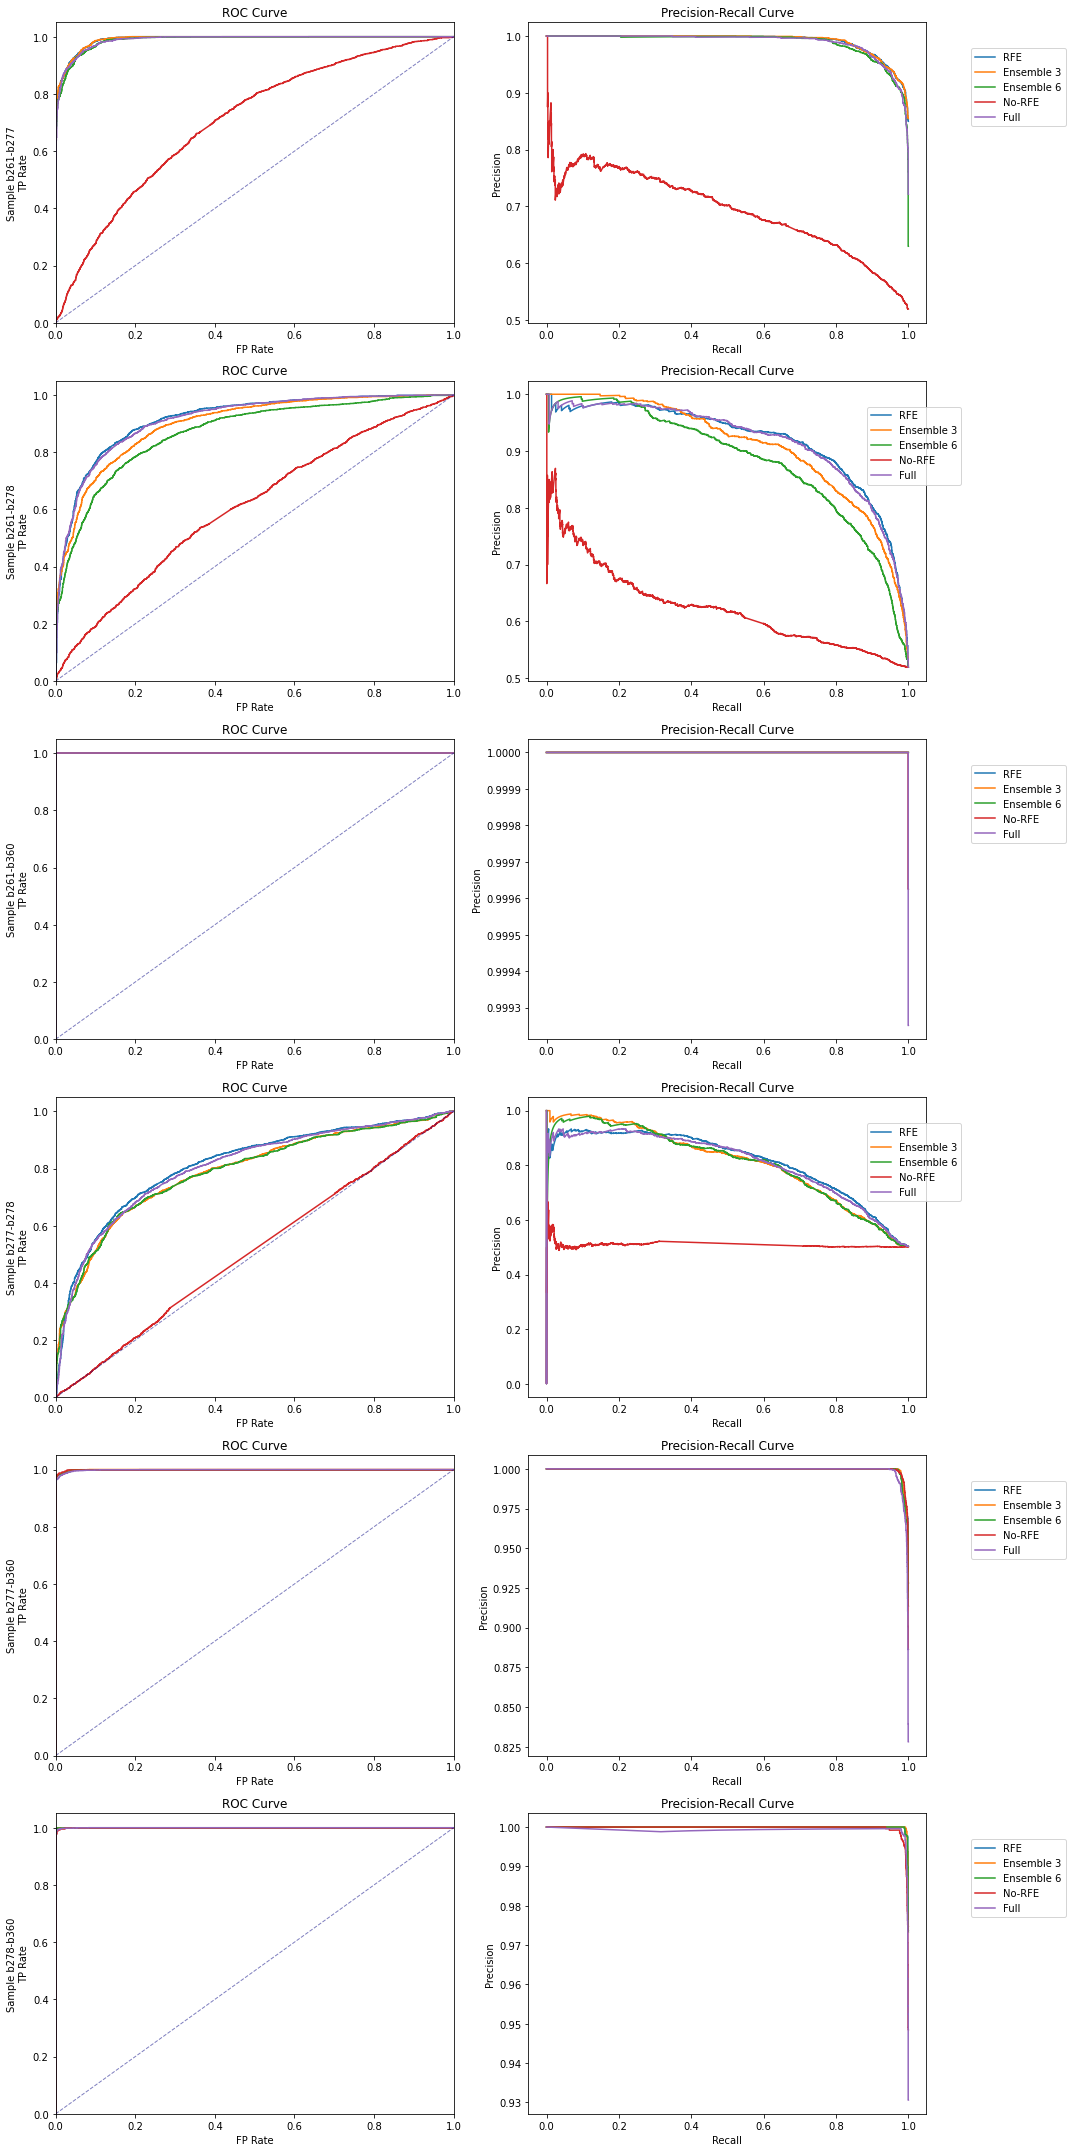

In [102]:
fig = plot_curves(buff_tiles)
fig.savefig("plots/rfe_curve.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [21]:
rows = []
for r in results:
    prec = metrics.precision_score(r.real_cls, r.predictions)
    rec = metrics.recall_score(r.real_cls, r.predictions)
    rows.append({"Model": r.clf_name, "Precision": prec, "Recall": rec, "AUC": r.roc_auc})
resume = pd.DataFrame(rows)
resume

,Model,Precision,Recall,AUC
0,RFE,0.992921,0.998501,0.999952
1,Ensemble 2,0.992921,0.998501,0.999965
2,Ensemble 3,0.992921,0.998501,0.999963
3,Ensemble 4,0.992921,0.998501,0.999965
4,Ensemble 5,0.992921,0.998501,0.999965
5,Ensemble 6,0.992921,0.998501,0.999965
6,No-RFE,0.987003,0.995879,0.999739
7,Full,0.987370,0.995879,0.999474


In [67]:
def execute_clf(*, clf_name, clasificator, train_df,  test_df, X_columns, y_column):
    clf = clasificator
    
    X_train = train_df[X_columns].values
    y_train = train_df[y_column].values
    
    X_test = test_df[X_columns].values
    y_test = test_df[y_column].values
    
    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    probabilities = clf.predict_proba(X_test)

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=1)
    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    print(metrics.classification_report(y_test, predictions))
    
    result = {
        "clf_name": clf_name,
        'fpr': fpr,
        'tpr': tpr,
        'thresh': thresholds,
        'roc_auc': roc_auc,
        'prec_rec_curve': prec_rec_curve,
        'real_cls': y_test,
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': metrics.confusion_matrix(y_test, predictions)}    
    
    return result

In [112]:
def get_clf():
    clf = RandomForestClassifier(**{
        'criterion': 'entropy',
        'max_features': "log2",
        'min_samples_split': 2,
        'n_estimators': 500,
        'n_jobs': -1})
    return {"clf_name": "RF", "clasificator": clf}

{'clf_name': 'RF',
 'clasificator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=None, max_features='log2',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                        warm_start=False)}

In [113]:
%%time
from collections import Counter


fname = "results/stars_RF_rfe.pkl.bz2"
if os.path.exists(fname):
    buff = joblib.load(fname)
else:
    buff = {}

keys = rdf.columns[rdf.columns.str.endswith(" Selected")].values

for tiles in keys:
    twotiles = tiles.split()[0].split("-")
    
    sample = pd.concat([data[twotiles[0]], data[twotiles[1]]])
    unscaled, sample,  scl = dataset.scale(sample)
    
    def cls_get(v):
        return 1 if v != "" else 0
    
    sample["cls"] = sample.vs_type.apply(cls_get)
    print(Counter(sample["cls"]))
    
    all_feats, selected, no_selected = split_feats(rdf, *twotiles)
    
    for tile_a, tile_b in [twotiles, reversed(twotiles)]:
        
        print("Starting:", tile_a, tile_b)
        if (tile_a, tile_b) not in buff:
            buff[(tile_a, tile_b)] = {}
            
        train = sample[sample.tile == tile_a]
        test = sample[sample.tile == tile_b]
        print(len(train), len(test))
    
        print(dt.datetime.now(), "FULL")
        if "full" not in buff[(tile_a, tile_b)]:
            clf = execute_clf(
                test_df=test, train_df=train, 
                X_columns=all_feats, y_column="cls", **get_clf())
            buff[(tile_a, tile_b)]["full"] = clf
            joblib.dump(buff, fname, compress=3)
        
        print(dt.datetime.now(), "RFE")
        if "rfe" not in buff[(tile_a, tile_b)]:
            clf = execute_clf(
                test_df=test, train_df=train, 
                X_columns=selected, y_column="cls", **get_clf())
            buff[(tile_a, tile_b)]["rfe"] = clf
            joblib.dump(buff, fname, compress=3)

        print(dt.datetime.now(), "NOT-RFE")
        if "nrfe" not in buff[(tile_a, tile_b)]:
            clf = execute_clf(
                test_df=test, train_df=train, 
                X_columns=no_selected, y_column="cls", **get_clf())
            buff[(tile_a, tile_b)]["nrfe"] = clf
            joblib.dump(buff, fname, compress=3)
    
        for ensn in [2, 3, 4, 5, 6]:
            ekey = f"rfe_ensemble{ensn}"
            ecolumns = globals()[ekey]
            print(dt.datetime.now(), f"RFE Ensemble {ensn}")

            if ekey not in buff[(tile_a, tile_b)]:
                clf = execute_clf(
                    test_df=test, train_df=train,
                    X_columns=ecolumns, y_column="cls", **get_clf())
                buff[(tile_a, tile_b)][ekey] = clf
                joblib.dump(buff, fname, compress=3)
    
        print("-" * 20)
    print("-" * 80)
    
buff_stars = buff
del buff

Counter({0: 4000, 1: 681})
Starting: b261 b277
2252 2429
2020-10-26 17:10:43.301515 FULL
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2000
           1       0.99      0.77      0.87       429

    accuracy                           0.96      2429
   macro avg       0.97      0.89      0.92      2429
weighted avg       0.96      0.96      0.96      2429

2020-10-26 17:10:46.240785 RFE
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2000
           1       0.83      0.82      0.83       429

    accuracy                           0.94      2429
   macro avg       0.90      0.89      0.90      2429
weighted avg       0.94      0.94      0.94      2429

2020-10-26 17:10:48.956489 NOT-RFE
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2000
           1       0.98      0.65      0.78       429

    accuracy               

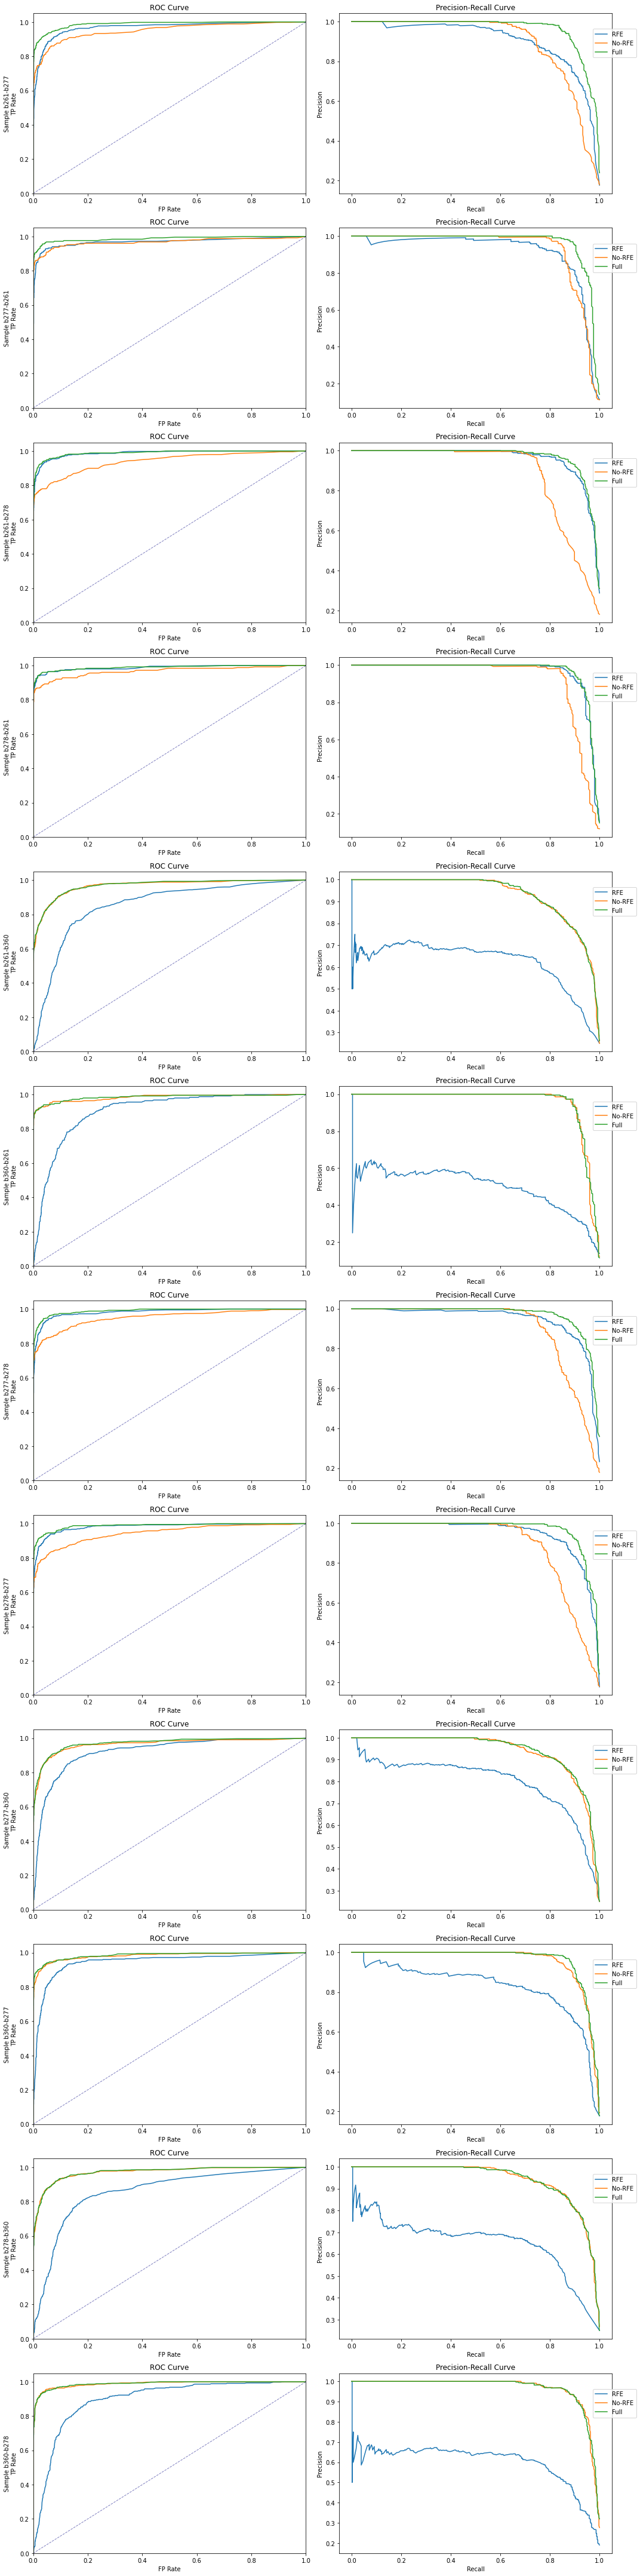

In [116]:
fig = plot_curves(buff_stars)
fig.savefig("plots/rfe_curve_stars_rf.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [78]:
ls

01_HP_selection.ipynb     08_clf.ipynb             __pycache__/
02_models.ipynb           dataset/                 README.md
03_models_analysis.ipynb  julynter_experiment.zip  requirements.txt
04_FS.ipynb               libs/                    results/
05_FS_analysis.ipynb      plots/                   script_04.py
06_all_cmp.ipynb          prueba.py
07_tables.ipynb           pruebas/
